# SMS Hitbox
[Grounded/Airborne Wall/Ground/Roof hitbox](https://twitter.com/naosan_RTA2/status/1490198481860186113) (made by naosan\[なおさん\])

## Import Libraries

In [1]:
import numpy as np
import struct
from memorylib import Dolphin
import matplotlib.pyplot as plt
from matplotlib import patches
import itertools
from collections import defaultdict, Counter
from shape import Polygon, Polyhedron
array = np.array
normalize = lambda x: x/np.linalg.norm(x)
read_struct = lambda addr, fmt: struct.unpack(fmt, d.read_ram(addr-0x80000000, struct.calcsize(fmt)))

def hook():
  global d, dolphin
  d = dolphin = Dolphin()
  assert dolphin.find_dolphin(), 'Dolphin not found'
  assert dolphin.init_shared_memory(), 'MEM1 not found'
  assert dolphin.read_ram(0, 3).tobytes() == b'GMS', 'Current game is not Sunshine'

In [2]:
hook()

2690796364432 0x2727ff62290


## Classes and Functions

In [3]:
class Surface:
  def __init__(self, surtype, surpara, trntype, unk7, verts, vidxs=None, n=None, c=None):
    self.surtype, self.surpara, self.trntype, self.unk7 = \
      surtype, surpara, trntype, unk7
    self.vidxs = vidxs
    self.verts = verts
    self.minY = verts[:,1].min()
    self.maxY = verts[:,1].max()
    self.n = normalize(np.cross(verts[1]-verts[0], verts[2]-verts[1])) if n is None else n
    self.c = -np.dot(verts[0], self.n) if c is None else c
  def __repr__(self):
    return 'minY=%.0f maxY=%.0f n=(%5.2f, %5.2f, %5.2f)'%(
      self.minY, self.maxY, *self.n,
    )
  
def checkList2list(ptr):
  ans = []
  while True:
    ptr, data = read_struct(ptr+4, '>II')
    ans.append(Surface(
      *read_struct(data, '>HHBB'),
      np.array(read_struct(data+0x10, '>9f'), 'f').reshape(3, 3),
      n=np.array(read_struct(data+0x34, '>3f'), 'f'),
      c=d.read_float(data+0x40),
    ))
    if ptr == 0: return ans

In [4]:
makeTriPrism = lambda tri0, tri1: Polyhedron([
  *tri0,
  *tri1,
], [e for i in range(3) for e in [(i, (i+1)%3), (i, i+3), (i+3, (i+1)%3+3)]])

def makeGround(tri, hG=0):
  poly = makeTriPrism(tri.verts+(0,hG,0), tri.verts-(0,108,0))
  poly.clipPlane(p=(0, tri.minY-30, 0), n=(0, 1, 0))
  return poly
def makeRoof(tri, hR=82):
  poly = makeTriPrism(tri.verts-(0,hR,0), tri.verts-(0,160,0))
  return poly
def makeWall(tri, rW=50, dy=30):
  verts = tri.verts - (0, dy, 0)
  n = tri.n
  off = (2*rW,0,0) if abs(n[0])>0.707 else (0,0,2*rW)
  poly = makeTriPrism(verts-off, verts+off)
  poly.clipPlane(p=verts[0], n=n, c=-rW)
  poly.clipPlane(p=verts[0], n=-n, c=-rW)
  return poly

# make collision: Polyhedron[]
def makeCol(tri, airborne=True):
  ny = tri.n[1]
  if ny > 0.2:
    return [makeGround(tri, 0 if airborne else 100)]
  elif ny < -0.2:
    return [makeRoof(tri, 82 if airborne else 2)]
  else:
    return [
      makeWall(tri, 50, 150),
      makeWall(tri, 50, 30),
    ] if airborne else [
      makeWall(tri, 25, 30),
      makeWall(tri, 50, 60),
    ]

## Draw wall hitboxs

### Get data from Dolphin

In [6]:
# mario
gpMarioOriginal = 0x8040A378
ptrMario = d.read_uint32(gpMarioOriginal)
x, y, z = read_struct(ptrMario+0x10, '>3f')

# get collision data (static collision)
gpMap = 0x8040A570
ptrMap = d.read_uint32(gpMap)
ptrCol = d.read_uint32(ptrMap+0x10)
xLimit, zLimit, xBlockCount, ptrStCLR = read_struct(ptrCol, '>ffI4x4xI')
## TBGCheckListRoot[zBlockCount][xBlockCount]
colOff = int((z+zLimit)//1024*xBlockCount + (x+xLimit)//1024)*36
## root->ground(12*2).next(4)
stWalls = checkList2list(d.read_uint32(ptrStCLR+colOff+4+12*2))

x, y, z

(-4762.12353515625, 230.0, 13479.6826171875)

### plot

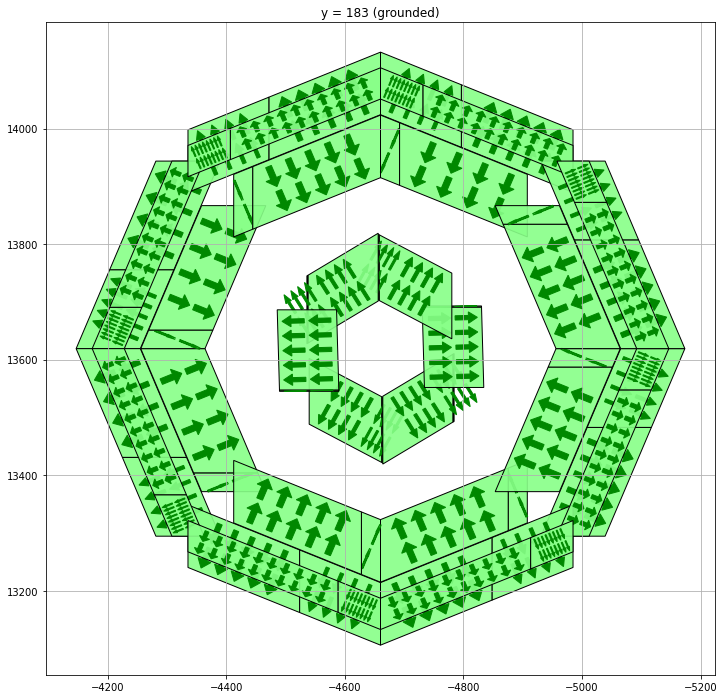

In [7]:
yy, airborne = 183, False
#yy, airborne = y, True

# paras
margin = 0.05
arsize0 = array([20, 10]) # arrow size (base)
arcnt = 5

# vars
fig, ax = plt.subplots(figsize=(12,12))
xyMax = np.full(2, -np.inf)
xyMin = np.full(2, np.inf)

# draw 2 hitboxs (draw in reverse order)
axes = [0, 2]
for ii in [1, 0]:
  polys = [
    (c, wall.n)
    for wall in stWalls
    for c in [makeCol(wall, airborne=airborne)[ii]]
    # FIXME: filtering walls
    if c.verts[:,2].max()<14200
  ]
  # arrow size scale (0.5 if radius is 25)
  awmul = 1.0 if airborne or ii == 1 else 0.5
  # draw wall hitboxs (draw in reverse order)
  for poly, n in polys[::-1]:
    # clip at y=yy and take (x, z) coordinate
    verts = poly.slicePlane((0, yy, 0), (0, 1, 0))[:,axes]
    p2 = Polygon(verts)
    path = p2.path # path to plot
    if path is None: continue # skip if no intersection
    # plot hitbox area
    patch = patches.PathPatch(path, facecolor='#88ff88e8', lw=1)
    ax.add_patch(patch)
    ## update x, y range
    xyMax = array([xyMax, *verts]).max(axis=0)
    xyMin = array([xyMin, *verts]).min(axis=0)
    # plot arrow (TODO: can be improved)
    ## center of the clipped polygon
    vc = np.mean(verts, axis=0)
    ## normal of the wall
    n2 = normalize(n[axes])
    ## direction vector (perpendicular to normal vector)
    l2 = np.array([-n2[1], n2[0]])
    loff = np.matmul(verts-vc, [n2[1], -n2[0]])
    loffp = loff[loff>0].min() if len(loff[loff>0]) else 0
    loffm = loff[loff<0].max() if len(loff[loff<0]) else 0
    loffdis = loffp-loffm
    larsize = np.dot(np.abs(l2), arsize0)
    arsize = ( # FIXME: there should be better way to determine arrow size
      loffdis/2 if loffdis<=larsize*2 else
      loffdis/4 if loffdis<=larsize*4 else
      larsize if loffdis<=larsize*arcnt else loffdis/arcnt
    )*awmul
    #if loffdis <= arsize: continue # if too small
    ## offset parallel to direction vector
    for loff in np.linspace(loffm+arsize*0.64, loffp-arsize*0.64, int(loffdis//arsize)) if loffdis>=arsize*2 else [0]:
      ## offset parallel to normal vector
      for off, l in [(-40, 37.5), (5.0, 37.5)]:
        plt.arrow(
          *vc+loff*l2+n2*off*awmul, *n2*l*awmul,
          width=arsize*0.27, head_width=arsize*0.72, head_length=15*awmul,
          length_includes_head=True, color='#080'
        )

# set x, y range of the figure
xMg, yMg = (xyMax-xyMin)*margin
xMax, yMax = xyMax
xMin, yMin = xyMin
ax.set_xlim(xMin-xMg, xMax+xMg)
ax.set_ylim(yMin-yMg, yMax+yMg)

# if needed
ax.invert_xaxis()
#ax.invert_yaxis()
ax.grid()

plt.title(f'y = %s (%s)'%(yy, 'airborne' if airborne else 'grounded'))
#fig.patch.set_facecolor('white')

plt.show()

## Draw all static triangle's hitbox

In [8]:
# mario
gpMarioOriginal = 0x8040A378
ptrMario = d.read_uint32(gpMarioOriginal)
x, y, z = read_struct(ptrMario+0x10, '>3f')

# get collision data (static collision)
gpMap = 0x8040A570
ptrMap = d.read_uint32(gpMap)
ptrCol = d.read_uint32(ptrMap+0x10)
xLimit, zLimit, xBlockCount, ptrStCLR = read_struct(ptrCol, '>ffI4x4xI')

## TBGCheckListRoot[zBlockCount][xBlockCount]
colOff = int((z+zLimit)//1024*xBlockCount + (x+xLimit)//1024)*36
## stGnds, stRoofs, stWalls
data1 = [
  checkList2list(d.read_uint32(ptrStCLR+colOff+4+12*j))
  for j in range(3)
]

## next z block
colOff = int(((z+zLimit)//1024+1)*xBlockCount + (x+xLimit)//1024)*36
data2 = [
  checkList2list(d.read_uint32(ptrStCLR+colOff+4+12*j))
  for j in range(3)
]

x, y, z

(-4645.99853515625, 864.3046264648438, 12823.865234375)

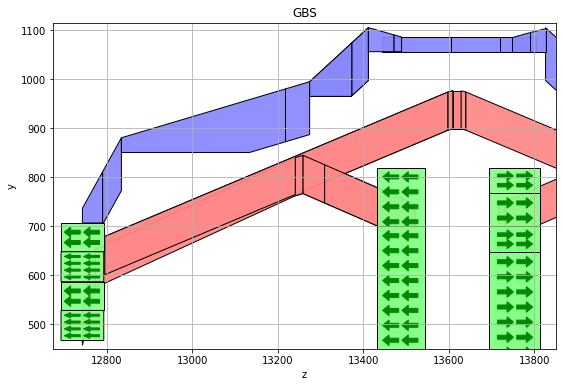

In [9]:
p0, pn = (x, y, z), (1, 0, 0)
airborne = True
axes = [2, 1] # (z, y)

# paras
margin = 0.01
arsize0 = array([30, 30]) # arrow size
arcnt = 30 # max arrow count

# vars
fig, ax = plt.subplots(figsize=(9, 6))
xyMax = np.full(2, -np.inf)
xyMin = np.full(2, np.inf)

for stGnds, stRoofs, stWalls in (data1, data2):
  for polys, awmul, alen, facecolor, arcolor in [
    # ceiling
    ([
      (c, array((0, -1, 0)))
      for tri in stRoofs
      for c in makeCol(tri, airborne=airborne)
      if tri.maxY >= 400
    ##], 1.0, 78.0 if airborne else 158.0, '#f88e', '#800'),
    ## FIXME: draw arrow
    ], 1.0, 0, '#f88e', '#800'),
    ([
      (c, array((0, 1, 0)))
      for tri in stGnds # TODO grounded hitbox
      for c in makeCol(tri, airborne=airborne)
      if tri.maxY >= 400
    ## FIXME: draw arrow
    ], 1.0, 0, '#88fe', '#008'), # TODO
    *(
      ([
        (c, tri.n)
        for tri in stWalls
        for c in [makeCol(tri, airborne=airborne)[ii]]
        if tri.maxY >= 400
      # arrow size scale (0.5 if radius is 25)
      ], 1.0 if airborne or ii == 1 else 0.5, 50.0, '#8f8e', '#080')
      for ii in (1, 0)
    ),
  ]:
    # draw wall hitboxs (draw in reverse order)
    for poly, n in polys[::-1]:
      # clip at y=yy and take (x, z) coordinate
      verts = poly.slicePlane(p0, pn)[:,axes]
      p2 = Polygon(verts)
      path = p2.path # path to plot
      if path is None: continue # skip if no intersection
      # plot hitbox area
      patch = patches.PathPatch(path, facecolor=facecolor, lw=1)
      ax.add_patch(patch)
      ## update x, y range
      xyMax = array([xyMax, *verts]).max(axis=0)
      xyMin = array([xyMin, *verts]).min(axis=0)
      # plot arrow (TODO: can be improved)
      ## center of the clipped polygon
      vc = np.mean(verts, axis=0)
      ## normal of the wall
      n2 = normalize(n[axes])
      ## direction vector (perpendicular to normal vector)
      l2 = np.array([-n2[1], n2[0]])
      loff = np.matmul(verts-vc, [n2[1], -n2[0]])
      loffp = loff[loff>0].min() if len(loff[loff>0]) else 0
      loffm = loff[loff<0].max() if len(loff[loff<0]) else 0
      loffdis = loffp-loffm
      larsize = np.dot(np.abs(l2), arsize0)
      arsize = ( # FIXME: there should be better way to determine arrow size
        loffdis/2 if loffdis<=larsize*2 else
        loffdis/4 if loffdis<=larsize*4 else
        larsize if loffdis<=larsize*arcnt else loffdis/arcnt
      )*awmul
      #if loffdis <= arsize: continue # if too small
      ## offset parallel to direction vector
      for loff in np.linspace(loffm+arsize*0.64, loffp-arsize*0.64, int(loffdis//arsize)) if loffdis>=arsize*2 else [0]:
        ## offset parallel to normal vector
        for off, l in [(alen*-0.8, alen*0.75), (alen*0.1, alen*0.75)]:
          plt.arrow(
            *vc+loff*l2+n2*off*awmul, *n2*l*awmul,
            width=arsize*0.27, head_width=arsize*0.72, head_length=15*awmul,
            length_includes_head=True, color=arcolor,
          )

# set x, y range of the figure
xMg, yMg = (xyMax-xyMin)*margin
xMax, yMax = xyMax
xMin, yMin = xyMin
ax.set_xlim(xMin-xMg, xMax+xMg)
ax.set_ylim(yMin-yMg, yMax+yMg)

# if needed
ax.set_xlim(xMin-xMg, 13850)
ax.set_ylim(450, yMax+yMg)
#ax.invert_xaxis()
#ax.invert_yaxis()
ax.grid()

#plt.title(f'z = %s (%s)'%(z, 'airborne' if airborne else 'grounded'))
plt.title('GBS')
fig.patch.set_facecolor('white')
plt.xlabel('z')
plt.ylabel('y')

#plt.savefig('GBS.jpg')
plt.show()